**Prévisions avec Séries Temporelles sur le Bitcoin**

Le Bitcoin est la cryptomonnaie la plus ancienne et la plus reconnue, lancée en open source en 2009 par l’anonyme Satoshi Nakamoto. Il agit comme un moyen d'échange numérique décentralisé, où les transactions sont vérifiées et enregistrées dans un registre distribué public (la blockchain), sans nécessiter une autorité centrale ou un intermédiaire de confiance. Chaque bloc de transactions contient un hachage cryptographique SHA-256 du bloc précédent, créant ainsi une chaîne continue et immuable de toutes les transactions passées.

Comme toute devise ou produit sur le marché, l'adoption du Bitcoin par le grand public a rapidement été suivie par le développement du trading et d'instruments financiers liés, et cette tendance continue de s'étendre. Si vous n'êtes pas familier avec le Bitcoin, il serait judicieux de se renseigner à son sujet. Ce projet est divisé en deux parties :



* Exploration des données
* Analyse des séries temporelles

Et pour la **prévision des séries temporelles :**

* Prévision des séries temporelles avec **LSTM**
* Prévision des séries temporelles avec **XGBoost**
* Prévision des séries temporelles avec **ARIMA**


In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

import matplotlib.pyplot as plt
import seaborn as sns


**Exploration des données**

Dans cette section, nous explorons simplement les données, c'est-à-dire les prix historiques du Bitcoin, et tentons de découvrir des insights. Nous utiliserons le jeu de données de Coinbase, car il s'agit de l'une des plateformes d'échange/portefeuille Bitcoin les plus utilisées au monde.


In [7]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))


# Chargement du fichier CSV
data = pd.read_csv('btcusd.csv')

# Conversion de la colonne 'Timestamp' en datetime, en gérant les NaN
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s', errors='coerce')

# Localisation en UTC pour la colonne de date
data['Timestamp'] = data['Timestamp'].apply(lambda x: pytz.utc.localize(x) if pd.notnull(x) else x)

# Affichage des premières lignes pour vérification
print(data.head())



                  Timestamp  Open  High   Low  Close  Volume
0 2012-01-01 10:01:00+00:00  4.58  4.58  4.58   4.58     0.0
1 2012-01-01 10:02:00+00:00  4.58  4.58  4.58   4.58     0.0
2 2012-01-01 10:03:00+00:00  4.58  4.58  4.58   4.58     0.0
3 2012-01-01 10:04:00+00:00  4.58  4.58  4.58   4.58     0.0
4 2012-01-01 10:05:00+00:00  4.58  4.58  4.58   4.58     0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6711281 entries, 0 to 6711280
Data columns (total 6 columns):
 #   Column     Dtype              
---  ------     -----              
 0   Timestamp  datetime64[ns, UTC]
 1   Open       float64            
 2   High       float64            
 3   Low        float64            
 4   Close      float64            
 5   Volume     float64            
dtypes: datetime64[ns, UTC](1), float64(5)
memory usage: 307.2 MB


Un petit prétraitement est nécessaire, en remplaçant les valeurs NaN par des zéros et des données précédentes.


In [11]:
# Vérifiez les noms des colonnes disponibles dans le DataFrame
print(data.columns)

# Remplacement des valeurs NaN par 0 pour les colonnes de volume et de prix
columns_to_fill_zero = ['Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']
for col in columns_to_fill_zero:
    if col in data.columns:
        data[col].fillna(value=0, inplace=True)

# Remplissage vers l'avant des valeurs manquantes pour les colonnes OHLC
columns_to_fill_ffill = ['Open', 'High', 'Low', 'Close']
for col in columns_to_fill_ffill:
    if col in data.columns:
        data[col].fillna(method='ffill', inplace=True)

# Affichage des premières lignes pour vérifier les modifications
print(data.head())

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
                  Timestamp  Open  High   Low  Close  Volume
0 2012-01-01 10:01:00+00:00  4.58  4.58  4.58   4.58     0.0
1 2012-01-01 10:02:00+00:00  4.58  4.58  4.58   4.58     0.0
2 2012-01-01 10:03:00+00:00  4.58  4.58  4.58   4.58     0.0
3 2012-01-01 10:04:00+00:00  4.58  4.58  4.58   4.58     0.0
4 2012-01-01 10:05:00+00:00  4.58  4.58  4.58   4.58     0.0


C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\2055709052.py:14: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Création de lignes hebdomadaires pour la visualisation des données


In [12]:
# create valid date range
start = datetime.datetime(2015, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2018, 11, 11, 0, 0, 0, 0, pytz.UTC)

# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = data[(data['Timestamp'] >= start) & (data['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
weekly_rows.head()

,Timestamp,Open,High,Low,Close,Volume
0,2015-01-05 00:00:00+00:00,316.67,316.67,316.67,316.67,1.336312
1,2015-01-12 00:00:00+00:00,276.80,276.80,276.80,276.80,0.000000
2,2015-01-19 00:00:00+00:00,270.98,271.01,270.98,271.01,0.229100
3,2015-01-26 00:00:00+00:00,212.27,212.27,211.54,212.21,10.892517
4,2015-02-02 00:00:00+00:00,263.47,263.47,263.47,263.47,2.482121


Visualisons les prix historiques du Bitcoin (2015-2018)


In [14]:
# Nous utilisons Plotly pour créer les graphiques
import plotly.graph_objs as go
from plotly.offline import iplot

# Création des traces avec les colonnes disponibles
trace1 = go.Scatter(
    x=weekly_rows['Timestamp'],
    y=weekly_rows['Open'].astype(float),
    mode='lines',
    name='Open'
)

trace2 = go.Scatter(
    x=weekly_rows['Timestamp'],
    y=weekly_rows['Close'].astype(float),
    mode='lines',
    name='Close'
)

# Utilisation de la colonne 'Close' à la place de 'Weighted_Price'
trace3 = go.Scatter(
    x=weekly_rows['Timestamp'],
    y=weekly_rows['Close'].astype(float),
    mode='lines',
    name='Close (Utilisé à la place de Weighted Avg)'
)

layout = dict(
    title='Historical Bitcoin Prices (2015-2018) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='1y', step='month', stepmode='backward'),
                dict(count=36, label='3y', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

data = [trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename="Time Series with Rangeslider")


C:\Users\Adrien\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\Adrien\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\Adrien\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



Visualisons le volume du marché historique du Bitcoin (2015-2018)

In [16]:
# Nous utilisons Plotly pour créer les graphiques
import plotly.graph_objs as go
from plotly.offline import iplot

# Vérifiez si la colonne 'Volume_(Currency)' existe, sinon utilisez une colonne alternative
if 'Volume_(Currency)' in weekly_rows.columns:
    trace1 = go.Scatter(
        x=weekly_rows['Timestamp'],
        y=weekly_rows['Volume_(Currency)'].astype(float),
        mode='lines',
        name='Bitcoin Volume (USD)'
    )
else:
    # Utilisez 'Volume' s'il n'y a pas de colonne 'Volume_(Currency)'
    trace1 = go.Scatter(
        x=weekly_rows['Timestamp'],
        y=weekly_rows['Volume'].astype(float),
        mode='lines',
        name='Bitcoin Volume (USD)'
    )

layout = dict(
    title='Historical Bitcoin Volume (USD) (2015-2018) with the slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='1y', step='month', stepmode='backward'),
                dict(count=36, label='3y', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename="Time Series with Rangeslider")


C:\Users\Adrien\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [17]:
# Vérification des colonnes disponibles avant utilisation
print(weekly_rows.columns)

# Vérifiez l'existence des colonnes 'Volume_(BTC)' et 'Weighted_Price'
if 'Volume_(BTC)' in weekly_rows.columns and 'Weighted_Price' in weekly_rows.columns:
    trace = go.Scattergl(
        y=weekly_rows['Volume_(BTC)'].astype(float),
        x=weekly_rows['Weighted_Price'].astype(float),
        mode='markers',
        marker=dict(
            color='#FFBAD2',
            line=dict(width=1)
        )
    )
else:
    # Utiliser des colonnes alternatives si les colonnes prévues n'existent pas
    print("Les colonnes 'Volume_(BTC)' et/ou 'Weighted_Price' sont absentes. Veuillez vérifier le nom exact des colonnes.")
    # Remplacez par d'autres colonnes appropriées si disponibles, par exemple :
    trace = go.Scattergl(
        y=weekly_rows['Volume'].astype(float) if 'Volume' in weekly_rows.columns else [0],
        x=weekly_rows['Close'].astype(float) if 'Close' in weekly_rows.columns else [0],
        mode='markers',
        marker=dict(
            color='#FFBAD2',
            line=dict(width=1)
        )
    )

layout = go.Layout(
    title='BTC Volume v/s USD',
    xaxis=dict(
        title='Weighted Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume BTC',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='compare_webgl')


Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Les colonnes 'Volume_(BTC)' et/ou 'Weighted_Price' sont absentes. Veuillez vérifier le nom exact des colonnes.


**Historique des prix du Bitcoin**

*  18 août 2008, le nom de domaine bitcoin.org est enregistré.
*  6 novembre 2010, la capitalisation boursière du Bitcoin atteint 1 million USD. Son taux de change sur MtGox atteint 0,50 USD par BTC.
*  2 juin 2011, le taux de change USD/BTC est de 10 USD par Bitcoin. Pendant 6 jours, la valeur du Bitcoin est fixée à 31,91 USD sur MtGox.
*  28 février 2013, le taux de change du Bitcoin dépasse 31,91 USD pour la première fois en 601 jours.
*  1er avril 2013, le taux de change du Bitcoin atteint 100 USD pour 1 BTC.
*  Janvier 2015, Coinbase lève 75 millions USD dans le cadre d'un tour de financement de série C, battant le précédent record pour une entreprise de Bitcoin.
*  Février 2015, le prix du Bitcoin atteint 262 USD.
*  Janvier 2017, après un rallye durant la majeure partie du second semestre 2016, le Bitcoin franchit la barre des 1 000 USD pour la première fois en 3 ans.
*  12 juin 2017, le taux de change du Bitcoin dépasse 3 000 USD par BTC.
*  29 novembre 2017, le prix du Bitcoin dépasse 10 000 USD.
*  18 décembre 2017, le Bitcoin atteint un record historique, mais n'atteint pas les 20 000 USD.
*  28 décembre 2017, le prix du Bitcoin chute après que la Corée du Sud annonce des mesures supplémentaires pour réguler le trading de Bitcoin, y compris la fermeture potentielle des échanges, au milieu des mouvements volatils sur le troisième plus grand marché de cryptomonnaies au monde.
*  31 octobre 2018, 6 300 USD, pour le 10e anniversaire du Bitcoin, le prix se maintient au-dessus de 6 000 USD pendant une période de volatilité historiquement basse.


**Prévision des séries temporelles**

Les données de séries temporelles sont des données expérimentales observées à différents moments dans le temps (généralement à intervalles réguliers, comme une fois par jour, par heure ou par minute). Par exemple, les données des ventes de billets d'avion par jour constituent une série temporelle. Cependant, le simple fait qu'une série d'événements ait un élément temporel ne la rend pas automatiquement une série temporelle, comme les dates des grandes catastrophes aériennes, qui sont espacées de manière aléatoire et ne constituent pas une série temporelle. Ces types de processus aléatoires sont appelés processus ponctuels.

Les séries temporelles ont plusieurs caractéristiques clés telles que la tendance, la saisonnalité et le bruit. La prévision est le processus de réalisation de prédictions sur l'avenir, basé sur les données passées et présentes.

Dans ce projet, nous tentons de réaliser une analyse des séries temporelles sur les données des prix historiques du Bitcoin. Comme nous pouvons le voir dans la section **Exploration des données**, les prix du Bitcoin ont été assez volatils et incohérents au fil des années. Il est très difficile de réaliser une analyse de séries temporelles sur des données aussi volatiles. Cependant, nous essayons ici d'explorer différents modèles de prévision des séries temporelles. Tous les modèles utilisés dans ce projet sont très basiques, et il existe une possibilité de modèles plus complexes et plus performants.

* Prévision des séries temporelles avec LSTM
* Prévision des séries temporelles avec XGBoost
* Prévision des séries temporelles avec Prophet de Facebook
* Prévision des séries temporelles avec ARIMA



**Prédiction avec LSTM**

Dans cette première section, nous utilisons LSTM (Long short-term memory). Les unités LSTM sont des unités d'un réseau de neurones récurrents (RNN). Un RNN composé d'unités LSTM est souvent appelé un réseau LSTM (ou simplement LSTM). Une unité LSTM classique est composée d'une cellule, d'une porte d'entrée, d'une porte de sortie et d'une porte d'oubli. La cellule mémorise des valeurs sur des intervalles de temps arbitraires et les trois portes régulent le flux d'informations entrant et sortant de la cellule.

Bien que LSTM ne soit pas idéal pour prévoir un marché turbulent comme celui du Bitcoin, nous tentons tout de même notre chance ici.


In [19]:
# Charger le jeu de données
data = pd.read_csv('btcusd_1-min_data.csv', parse_dates=[0])

# S'assurer que la colonne 'Timestamp' est correctement formatée et sans fuseau horaire
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s', errors='coerce')
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)

# Regrouper les données par heure et prendre la première occurrence de chaque période
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()

# Mettre la colonne 'Timestamp' comme index
data = data.set_index('Timestamp')

# Utiliser la colonne 'Close' à la place de 'Weighted_Price' si elle n'existe pas
if 'Weighted_Price' not in data.columns:
    print("La colonne 'Weighted_Price' est absente. Utilisation de 'Close' à la place.")
    data['Weighted_Price'] = data['Close'] if 'Close' in data.columns else data['Open']

# Remplir les valeurs manquantes avec un remplissage vers l'avant
data['Weighted_Price'].fillna(method='ffill', inplace=True)

# Vérifier les premières lignes
print(data.head())


C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\1803070779.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\1803070779.py:5: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.



La colonne 'Weighted_Price' est absente. Utilisation de 'Close' à la place.
                     Open  High   Low  Close  Volume  Weighted_Price
Timestamp                                                           
2012-01-01 10:00:00  4.58  4.58  4.58   4.58     0.0            4.58
2012-01-01 11:00:00  4.58  4.58  4.58   4.58     0.0            4.58
2012-01-01 12:00:00  4.58  4.58  4.58   4.58     0.0            4.58
2012-01-01 13:00:00  4.58  4.58  4.58   4.58     0.0            4.58
2012-01-01 14:00:00  4.58  4.58  4.58   4.58     0.0            4.58


C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\1803070779.py:20: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Pour l'entraînement et le test, nous prenons le '25 juin 2018' comme date de séparation. Il y a eu une baisse considérable des prix du Bitcoin entre la période de juin à juillet 2018. Si nous regardons les prix historiques, le marché saisonnier a commencé à remonter à partir de cette date après avoir atteint son point le plus bas, bien que le prix ait atteint un niveau encore plus bas de 5 972 dollars le 29 juin 2018. Après avoir atteint la marque historique des 20 000$ le 18 décembre, il y a eu plusieurs baisses et le prix du marché a été corrigé à chaque fois.

C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\1338986273.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\1338986273.py:5: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.



La colonne 'Weighted_Price' est absente. Utilisation de 'Close' à la place.


C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\1338986273.py:20: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



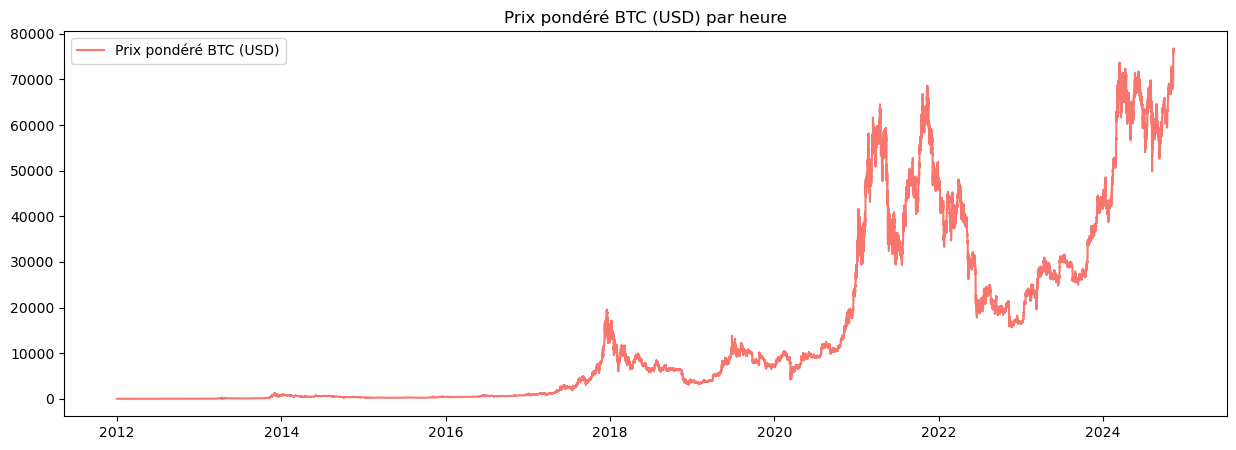

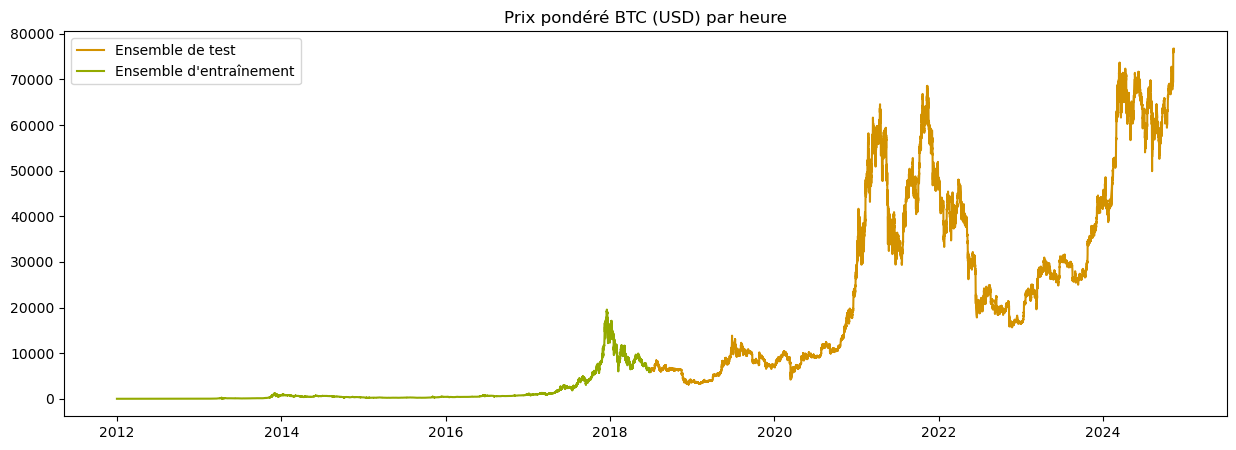

In [21]:
# Charger le jeu de données
data = pd.read_csv('btcusd_1-min_data.csv', parse_dates=[0])

# S'assurer que la colonne 'Timestamp' est correctement formatée et sans fuseau horaire
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s', errors='coerce')
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)

# Regrouper les données par heure et prendre la première occurrence de chaque période
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()

# Mettre la colonne 'Timestamp' comme index
data = data.set_index('Timestamp')

# Utiliser la colonne 'Close' à la place de 'Weighted_Price' si elle n'existe pas
if 'Weighted_Price' not in data.columns:
    print("La colonne 'Weighted_Price' est absente. Utilisation de 'Close' à la place.")
    data['Weighted_Price'] = data['Close'] if 'Close' in data.columns else data['Open']

# Remplir les valeurs manquantes avec un remplissage vers l'avant
data['Weighted_Price'].fillna(method='ffill', inplace=True)

# Séparation des données
split_date = '25-Jun-2018'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

# Prétraitement des données
training_set = data_train['Weighted_Price'].values.reshape(-1, 1)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

# Visualisation des données complètes
import matplotlib.pyplot as plt

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

plt.figure(figsize=(15, 5))
plt.plot(data.index, data['Weighted_Price'], color=color_pal[0], label='Prix pondéré BTC (USD)')
plt.title('Prix pondéré BTC (USD) par heure')
plt.legend()
plt.show()

# Renommer les colonnes avant la jointure pour éviter les conflits de noms
data_test_renamed = data_test.rename(columns={'Weighted_Price': 'Ensemble de test'})
data_train_renamed = data_train.rename(columns={'Weighted_Price': 'Ensemble d\'entraînement'})

# Jointure des ensembles d'entraînement et de test avec des suffixes pour éviter le chevauchement
merged_data = data_test_renamed.join(data_train_renamed, how='outer', lsuffix='_test', rsuffix='_train')

# Visualisation des ensembles de test et d'entraînement
plt.figure(figsize=(15, 5))
plt.plot(merged_data.index, merged_data['Ensemble de test'], color=color_pal[1], label='Ensemble de test')
plt.plot(merged_data.index, merged_data['Ensemble d\'entraînement'], color=color_pal[2], label='Ensemble d\'entraînement')
plt.title('Prix pondéré BTC (USD) par heure')
plt.legend()
plt.show()


Nous utiliserons ici un LSTM classique pour la prévision. Le modèle est entraîné sur les données antérieures au 25 juin 2018.

Epoch 1/100


C:\Users\Adrien\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1136/1136 - 3s - 3ms/step - loss: 0.0222
Epoch 2/100
1136/1136 - 1s - 1ms/step - loss: 0.0052
Epoch 3/100
1136/1136 - 1s - 1ms/step - loss: 0.0028
Epoch 4/100
1136/1136 - 1s - 1ms/step - loss: 0.0019
Epoch 5/100
1136/1136 - 1s - 1ms/step - loss: 0.0013
Epoch 6/100
1136/1136 - 1s - 1ms/step - loss: 0.0011
Epoch 7/100
1136/1136 - 1s - 1ms/step - loss: 8.6512e-04
Epoch 8/100
1136/1136 - 1s - 1ms/step - loss: 7.4576e-04
Epoch 9/100
1136/1136 - 1s - 1ms/step - loss: 6.2151e-04
Epoch 10/100
1136/1136 - 1s - 1ms/step - loss: 5.5494e-04
Epoch 11/100
1136/1136 - 1s - 1ms/step - loss: 4.8383e-04
Epoch 12/100
1136/1136 - 2s - 1ms/step - loss: 4.3658e-04
Epoch 13/100
1136/1136 - 2s - 1ms/step - loss: 3.9739e-04
Epoch 14/100
1136/1136 - 1s - 1ms/step - loss: 3.6384e-04
Epoch 15/100
1136/1136 - 1s - 1ms/step - loss: 3.3553e-04
Epoch 16/100
1136/1136 - 2s - 1ms/step - loss: 3.0964e-04
Epoch 17/100
1136/1136 - 1s - 1ms/step - loss: 2.8241e-04
Epoch 18/100
1136/1136 - 1s - 1ms/step - loss: 2.7927e-04
E

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,069 (781.52 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,380 (521.02 KB)

1748/1748 ━━━━━━━━━━━━━━━━━━━━ 2s 776us/step
MSE: 271671379.2053335
MAE: 9579.725786646066


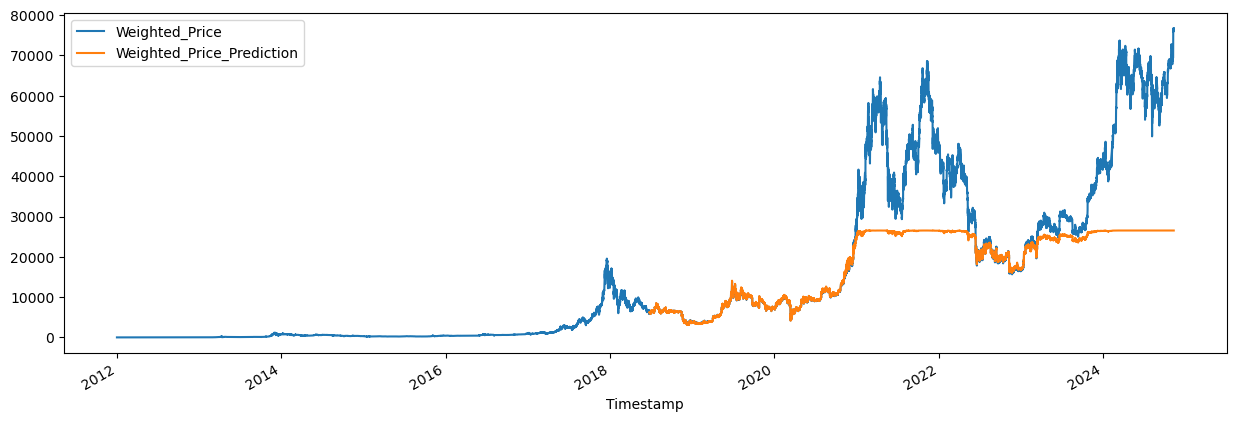

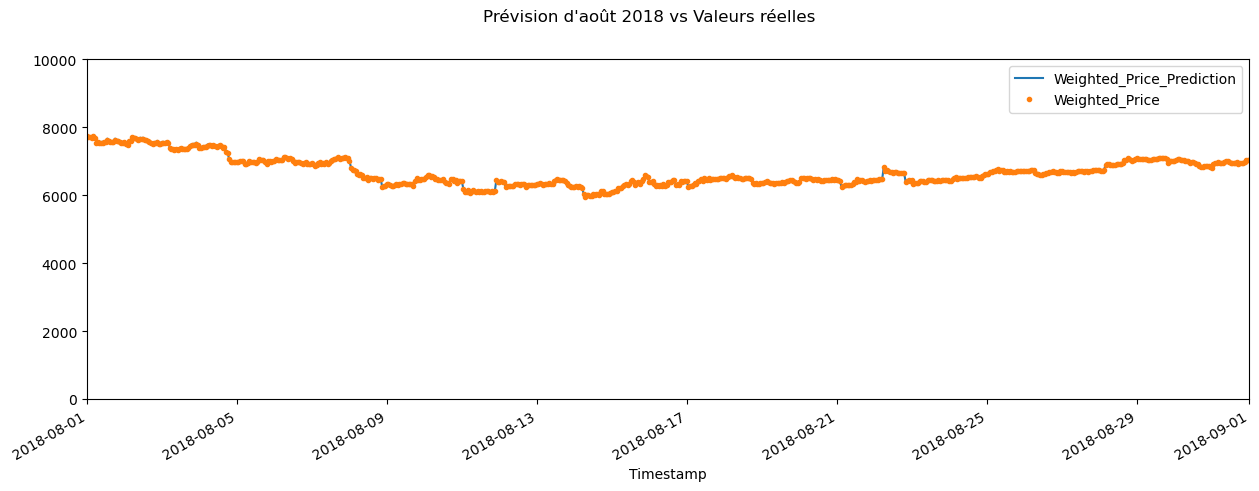

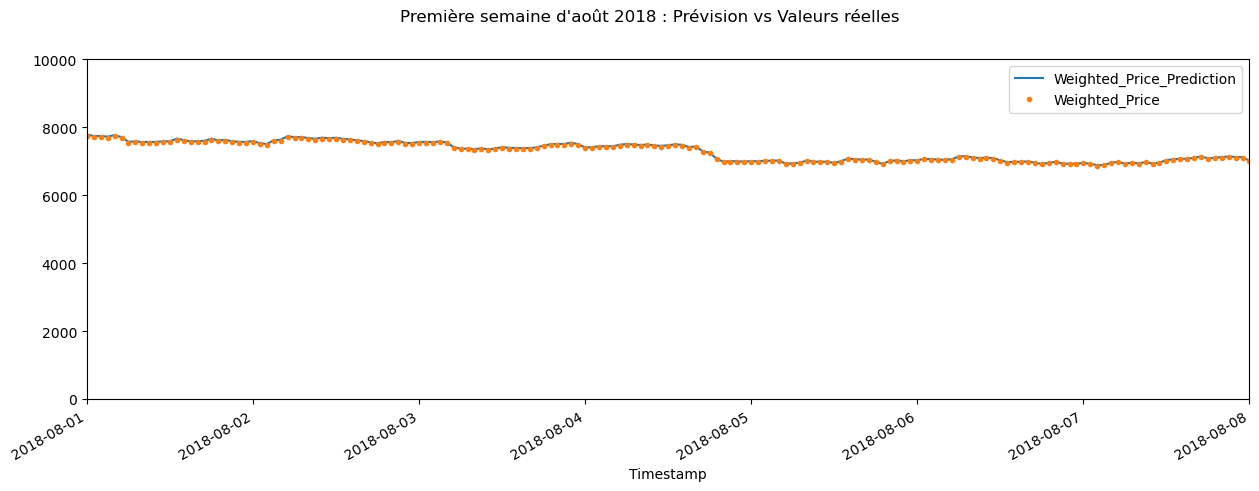

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# Construction du modèle LSTM

model = Sequential()
model.add(LSTM(128, activation="sigmoid", input_shape=(1, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam())
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

# Affichage du résumé du modèle
model.summary()

# Prédiction des prix
test_set = data_test['Weighted_Price'].values.reshape(-1, 1)
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

# Enregistrement des prédictions dans le DataFrame de test
data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

# Sauvegarde des valeurs prédites dans un DataFrame commun pour comparaison future
final_data = data_all.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Timestamp', 'Weighted_Price', 'lstm']]

# Affichage des graphiques des valeurs réelles et prédites
_ = data_all[['Weighted_Price', 'Weighted_Price_Prediction']].plot(figsize=(15, 5))

# Tracé de la prévision avec les valeurs réelles (août 2018)
f, ax = plt.subplots(1, figsize=(15, 5))
data_all[['Weighted_Price_Prediction', 'Weighted_Price']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='08-01-2018', upper='09-01-2018')
ax.set_ylim(0, 10000)
plt.suptitle('Prévision d\'août 2018 vs Valeurs réelles')

# Tracé de la première semaine d'août 2018
f, ax = plt.subplots(1, figsize=(15, 5))
data_all[['Weighted_Price_Prediction', 'Weighted_Price']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='08-01-2018', upper='08-08-2018')
ax.set_ylim(0, 10000)
plt.suptitle('Première semaine d\'août 2018 : Prévision vs Valeurs réelles')

# Calcul du MSE et du MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true=data_test['Weighted_Price'],
                         y_pred=data_test['Weighted_Price_Prediction'])
mae = mean_absolute_error(y_true=data_test['Weighted_Price'],
                          y_pred=data_test['Weighted_Price_Prediction'])

print(f"MSE: {mse}")
print(f"MAE: {mae}")


Nous pouvons clairement voir que le modèle entier est en sur apprentissage.

**Prévision des séries temporelles avec XGBoost**

XGBoost est une implémentation des arbres de décision boostés par gradient, conçue pour la rapidité et la performance. XGBoost est un outil puissant et polyvalent. Voyons comment XGBoost se comporte lorsqu'il est utilisé pour prédire les valeurs futures d'une série temporelle, comme les prix du Bitcoin.

C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\3722841092.py:11: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\3722841092.py:12: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.



Colonnes disponibles : Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
La colonne 'Weighted_Price' n'existe pas. Utilisation de la colonne 'Close' à la place.


C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\3722841092.py:28: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



ValueError: columns overlap but no suffix specified: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

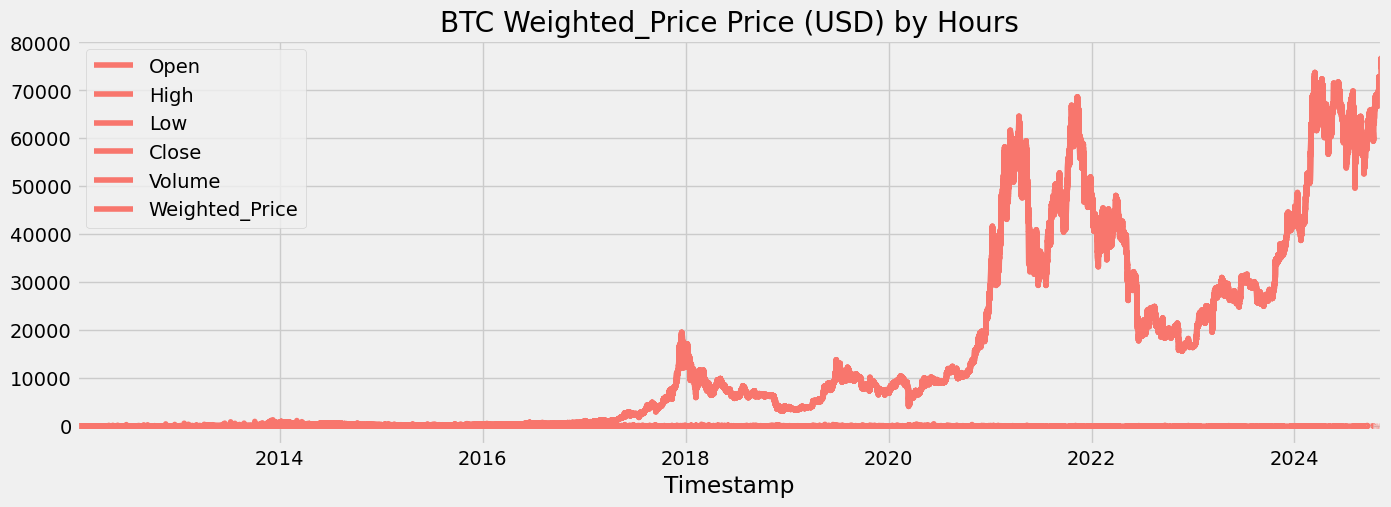

In [39]:
# Importation des bibliothèques
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet  
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
plt.style.use('fivethirtyeight')

# Charger le jeu de données
data = pd.read_csv('btcusd_1-min_data.csv', parse_dates=[0])
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s', errors='coerce')
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)

# Regrouper les données par heure et prendre la première occurrence
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')

# Vérification des colonnes disponibles
print("Colonnes disponibles :", data.columns)

# Si 'Weighted_Price' n'existe pas, utilisez une colonne alternative
if 'Weighted_Price' not in data.columns:
    print("La colonne 'Weighted_Price' n'existe pas. Utilisation de la colonne 'Close' à la place.")
    data['Weighted_Price'] = data['Close'] if 'Close' in data.columns else data['Open']

# Remplir les valeurs manquantes
data['Weighted_Price'].fillna(method='ffill', inplace=True)

# Visualisation des données
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15, 5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

# Séparation des ensembles d'entraînement et de test
split_date = '25-Jun-2018'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15, 5), title='BTC Weighted_Price Price (USD) by Hours', style='')

# Création des caractéristiques temporelles
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week  # Remplacement de weekofyear obsolète

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X_train, y_train = create_features(data_train, label='Weighted_Price')
X_test, y_test = create_features(data_test, label='Weighted_Price')

# Modèle XGBRegressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Remplacement de 'reg:linear' qui est obsolète
    min_child_weight=10,
    booster='gbtree',
    colsample_bytree=0.3,
    learning_rate=0.1,
    max_depth=5,
    alpha=10,
    n_estimators=100
)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=50,
          verbose=False)  # Changez `verbose=True` pour voir l'entraînement

# Prédictions
data_test['Weighted_Price_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

# Ajout des valeurs prédites au DataFrame final
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'xgboost'})
final_data = final_data[['Timestamp', 'Weighted_Price', 'lstm', 'xgboost']]

# Affichage des graphiques des prévisions et des valeurs réelles
_ = data_all[['Weighted_Price', 'Weighted_Price_Prediction']].plot(figsize=(15, 5))

# Tracé de la prévision pour août 2018
f, ax = plt.subplots(1, figsize=(15, 5))
data_all[['Weighted_Price_Prediction', 'Weighted_Price']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='08-01-2018', upper='09-01-2018')
ax.set_ylim(0, 10000)
plt.suptitle('Prévision d\'août 2018 vs Valeurs réelles')

# Tracé de la première semaine d'août 2018
f, ax = plt.subplots(1, figsize=(15, 5))
data_all[['Weighted_Price_Prediction', 'Weighted_Price']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='08-01-2018', upper='08-08-2018')
ax.set_ylim(0, 10000)
plt.suptitle('Première semaine d\'août 2018 : Prévision vs Valeurs réelles')

# Calcul du MSE et du MAE
mse = mean_squared_error(y_true=data_test['Weighted_Price'], y_pred=data_test['Weighted_Price_Prediction'])
mae = mean_absolute_error(y_true=data_test['Weighted_Price'], y_pred=data_test['Weighted_Price_Prediction'])

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


**Prévision des séries temporelles avec Prophet**

Prophet est une procédure de prévision des données de séries temporelles basée sur un modèle additif où les tendances non linéaires s'ajustent avec une saisonnalité annuelle, hebdomadaire et quotidienne, ainsi que des effets de jours fériés. Il fonctionne particulièrement bien avec des séries temporelles qui présentent de forts effets saisonniers et plusieurs saisons de données historiques. Prophet est robuste face aux données manquantes et aux changements de tendance, et gère généralement bien les valeurs aberrantes.

Le package Prophet offre des paramètres intuitifs qui sont faciles à ajuster. Même une personne ayant une expertise minimale en modèles de prévision peut l'utiliser pour réaliser des prédictions significatives pour divers problèmes dans un contexte d'entreprise.





C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\3668481811.py:11: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\3668481811.py:12: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.



Colonnes disponibles : Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
La colonne 'Weighted_Price' est absente. Utilisation de la colonne 'Close' à la place.


C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\3668481811.py:24: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



ValueError: columns overlap but no suffix specified: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

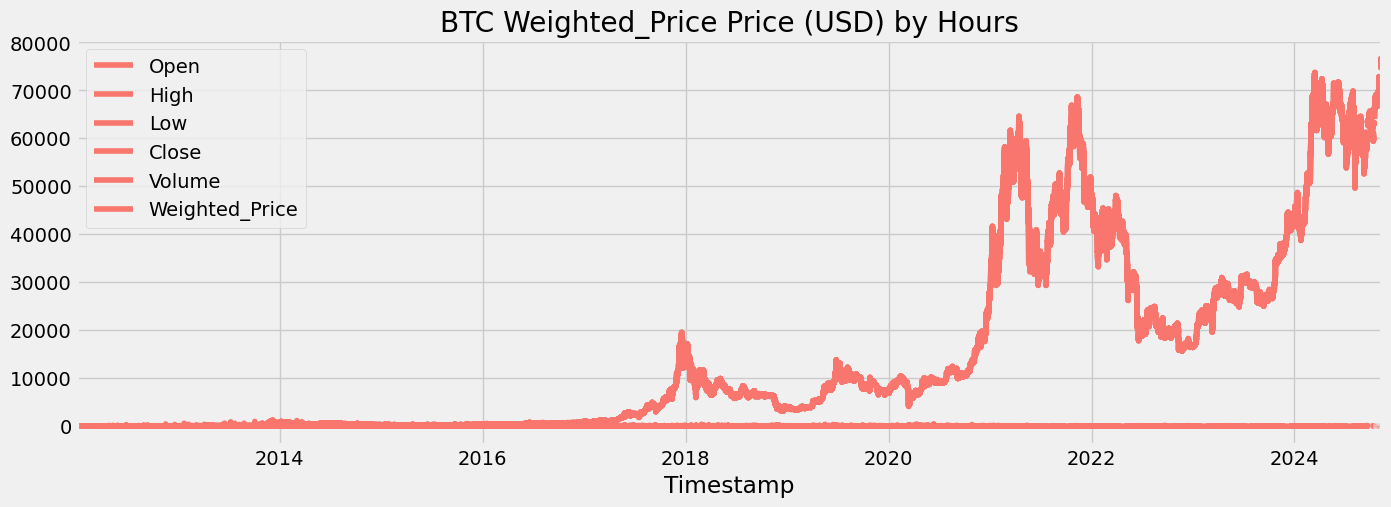

In [41]:
# Importation des bibliothèques nécessaires
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet  # Assurez-vous que Prophet est installé
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objects as go
from plotly.offline import iplot

# Charger le jeu de données et vérifier les colonnes
data = pd.read_csv('btcusd_1-min_data.csv', parse_dates=[0])
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s', errors='coerce')
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)

# Vérifiez les colonnes disponibles
print("Colonnes disponibles :", data.columns)

# Utiliser une colonne alternative si 'Weighted_Price' n'existe pas
if 'Weighted_Price' not in data.columns:
    print("La colonne 'Weighted_Price' est absente. Utilisation de la colonne 'Close' à la place.")
    data['Weighted_Price'] = data['Close'] if 'Close' in data.columns else data['Open']

# Remplir les valeurs manquantes
data['Weighted_Price'].fillna(method='ffill', inplace=True)

# Regrouper les données par heure et prendre la première occurrence
data = data.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data = data.set_index('Timestamp')

# Visualisation des données
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15, 5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

# Séparation des ensembles d'entraînement et de test
split_date = '25-Jun-2018'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

# Visualisation de la séparation
_ = data_test \
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15, 5), title='BTC Weighted_Price Price (USD) by Hours', style='')

data_train = data_train.reset_index().rename(columns={'Timestamp': 'ds', 'Weighted_Price': 'y'})

# Configuration et entraînement du modèle Prophet
model = Prophet()
model.fit(data_train)

# Prédictions sur l'ensemble de test
data_test_fcst = model.predict(df=data_test.reset_index().rename(columns={'Timestamp': 'ds'}))

# Tracé de la prévision
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_test_fcst, ax=ax)

# Tracé des composants
fig = model.plot_components(data_test_fcst)

# Tracé de la prévision avec les valeurs réelles
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r')
fig = model.plot(data_test_fcst, ax=ax)

# Pour la comparaison des prédictions
data_fcst = data_test_fcst.rename(columns={'ds': 'Timestamp'})
data_all = pd.concat([data_fcst, data_train], sort=False)

# Fusion des données pour la comparaison des modèles
try:
    final_data = pd.merge(final_data, data_all, sort=False)
except NameError:
    final_data = data_all
final_data = final_data.rename(columns={'yhat': 'prophet'})
final_data = final_data[['Timestamp', 'Weighted_Price', 'lstm', 'xgboost', 'prophet']]

# Tracé de la prévision pour août 2018 avec les valeurs réelles
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
ax.set_xbound(lower='08-01-2018', upper='09-01-2018')
ax.set_ylim(0, 10000)
plot = plt.suptitle('August 2018 Forecast vs Actuals')

# Tracé de la première semaine d'août 2018
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(data_test.index, data_test['Weighted_Price'], color='r')
fig = model.plot(data_test_fcst, ax=ax)
ax.set_xbound(lower='08-01-2018', upper='08-08-2018')
ax.set_ylim(0, 10000)
plot = plt.suptitle('First Week of August 2018 Forecast vs Actuals')

# Calcul du MSE et du MAE
mse = mean_squared_error(y_true=data_test['Weighted_Price'], y_pred=data_test_fcst['yhat'])
mae = mean_absolute_error(y_true=data_test['Weighted_Price'], y_pred=data_test_fcst['yhat'])

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

# Comparaison des résultats prédictifs de LSTM, XGBoost et Prophet
trace0 = go.Scatter(
    x=final_data['Timestamp'],
    y=final_data['Weighted_Price'],
    mode='lines+markers',
    name='Real Price'
)
trace1 = go.Scatter(
    x=final_data['Timestamp'],
    y=final_data['lstm'],
    mode='lines+markers',
    name='LSTM Prediction'
)
trace2 = go.Scatter(
    x=final_data['Timestamp'],
    y=final_data['xgboost'],
    mode='lines+markers',
    name='XGBoost Prediction'
)
trace3 = go.Scatter(
    x=final_data['Timestamp'],
    y=final_data['prophet'],
    mode='lines+markers',
    name='Prophet Prediction'
)

# Mise en page du graphique
layout = dict(title='Comparison of LSTM, XGBoost, and Prophet',
              xaxis=dict(title='Month'),
              yaxis=dict(title='Prices (USD)'))

data = [trace0, trace1, trace2, trace3]
fig = dict(data=data, layout=layout)
iplot(fig, filename='styled-line')


**Prévision des séries temporelles avec ARIMA**

ARIMA est un acronyme qui signifie AutoRegressive Integrated Moving Average (moyenne mobile intégrée autorégressive). C'est une classe de modèles qui capture un ensemble de différentes structures temporelles standard dans les données de séries temporelles.
Cet acronyme est descriptif et capture les aspects clés du modèle lui-même. En résumé, il s'agit de :
* AR : Autoregression. Un modèle qui utilise la relation de dépendance entre une observation et un certain nombre d'observations décalées.
* I : Intégré. L'utilisation de la différenciation des observations brutes (par exemple, soustraire une observation de celle de l'étape temporelle précédente) afin de rendre la série temporelle stationnaire.
* MA : Moyenne mobile. Un modèle qui utilise la dépendance entre une observation et une erreur résiduelle provenant d'un modèle de moyenne mobile appliqué aux observations décalées.


C:\Users\Adrien\AppData\Local\Temp\ipykernel_4612\2341038220.py:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



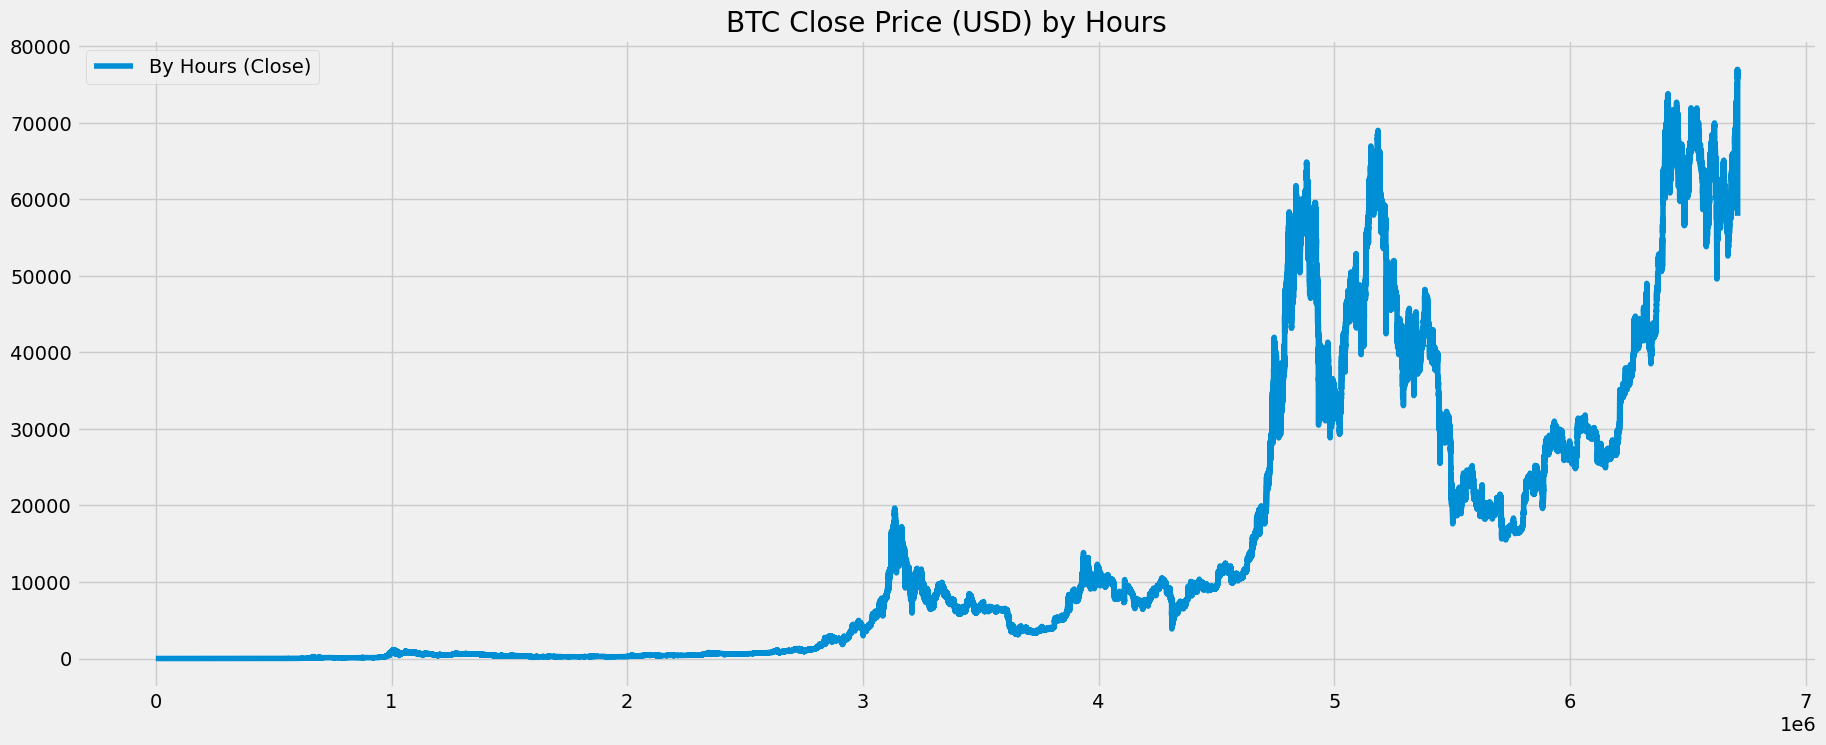

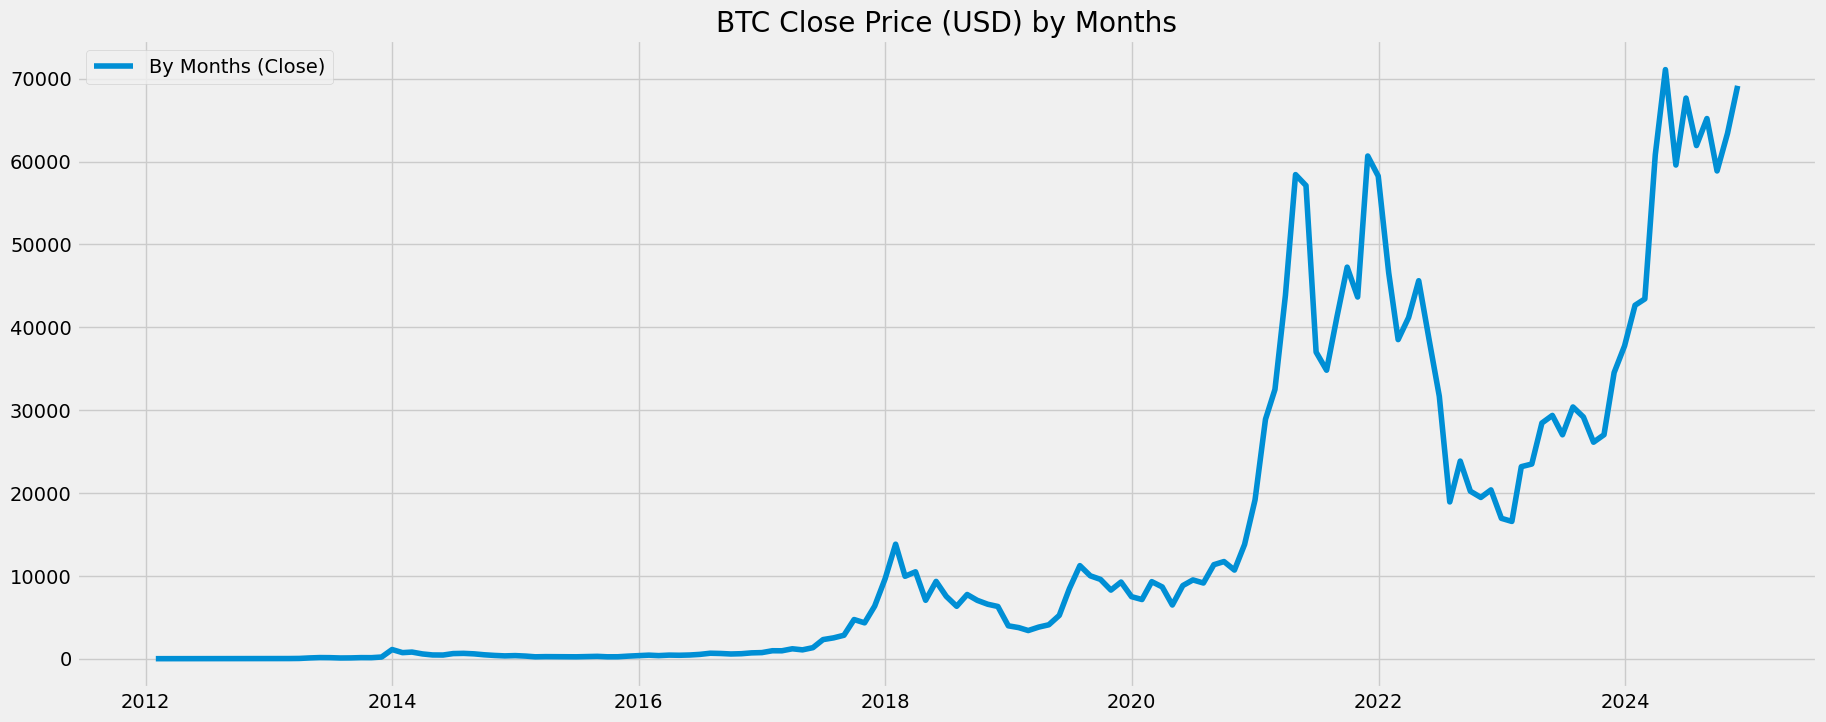

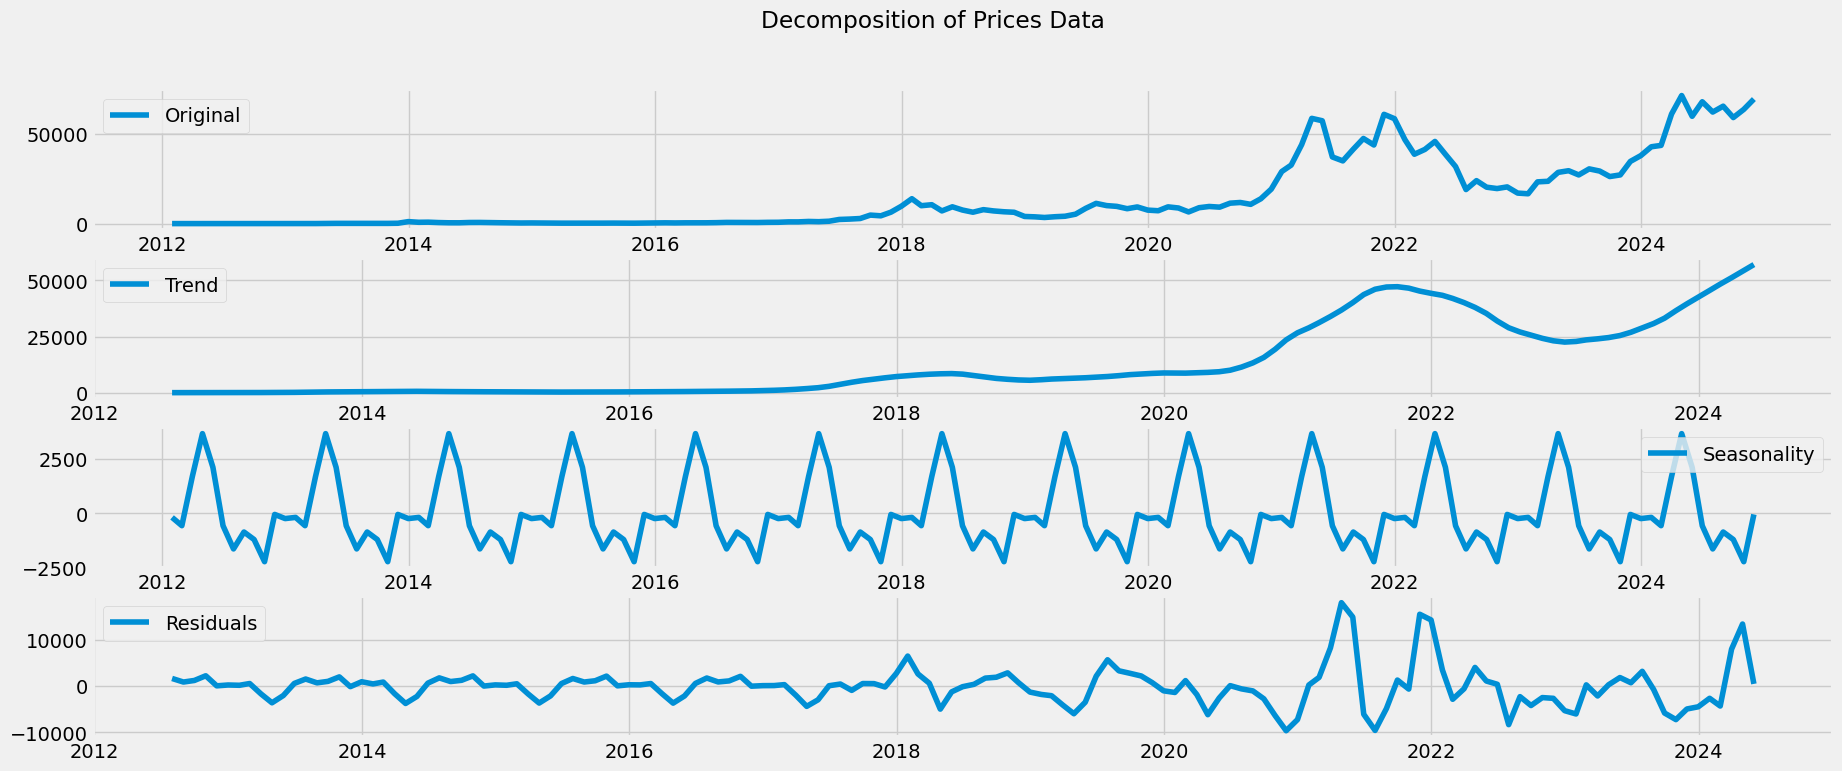

Dickey–Fuller test: p=0.955193


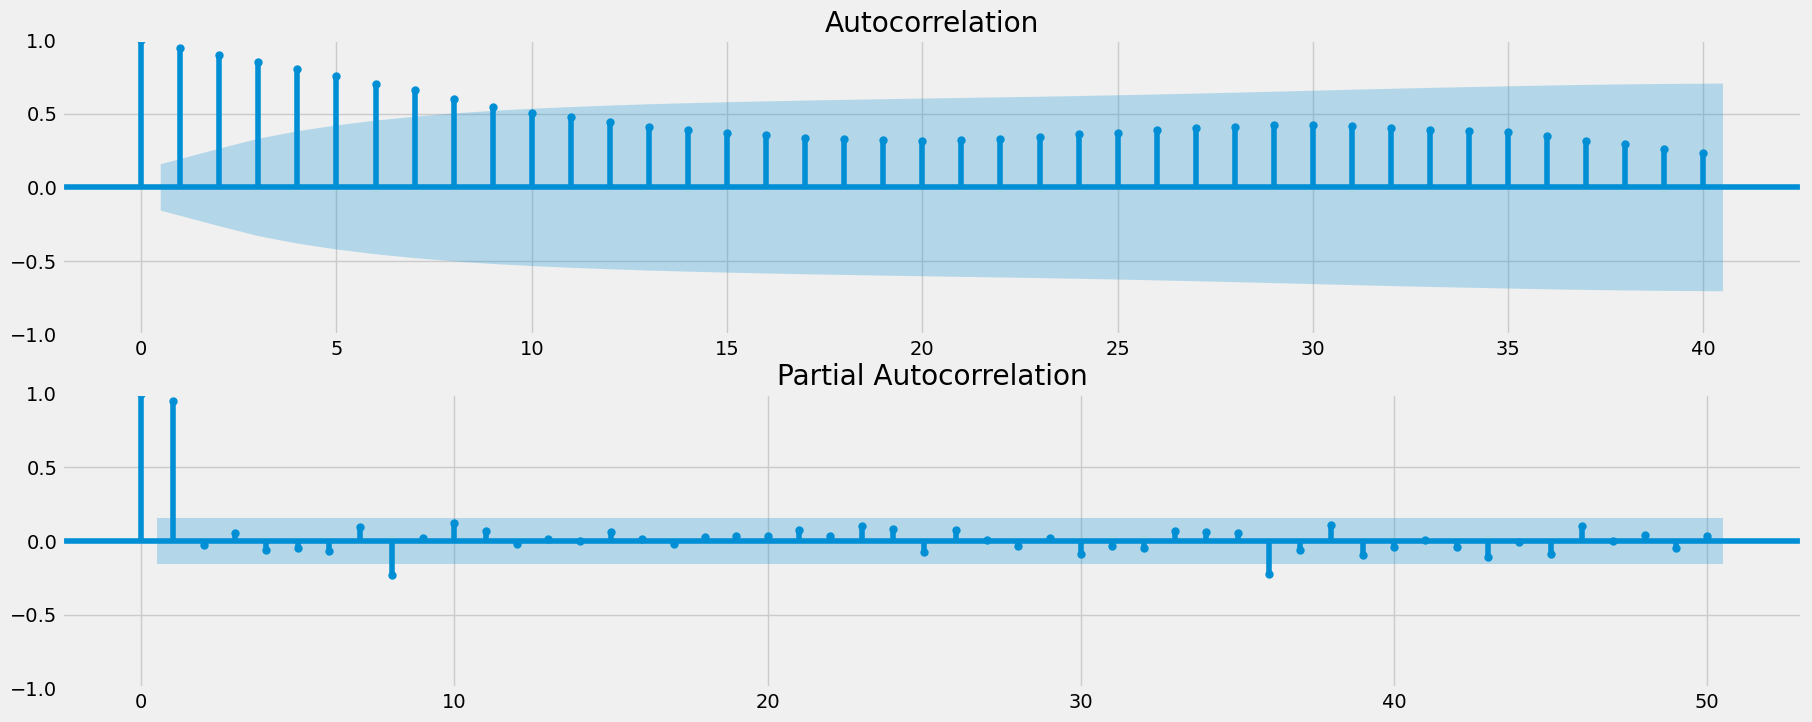

In [44]:
# Importation des bibliothèques nécessaires
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import warnings

# Charger le jeu de données
data = pd.read_csv('btcusd_1-min_data.csv', parse_dates=[0])
data['Timestamp'] = pd.to_datetime(pd.to_numeric(data['Timestamp'], errors='coerce'), unit='s', errors='coerce')
data['Timestamp'] = data['Timestamp'].dt.tz_localize(None)

# Vérifier la présence des colonnes et remplir les valeurs manquantes
columns_to_fill = ['Open', 'High', 'Low', 'Close', 'Weighted_Price', 'Volume_(BTC)', 'Volume_(Currency)']
for col in columns_to_fill:
    if col in data.columns:
        data[col] = data[col].ffill()

# Utilisation de la colonne 'Close' si 'Weighted_Price' est absente
if 'Weighted_Price' in data.columns:
    column_to_plot = 'Weighted_Price'
else:
    column_to_plot = 'Close'  # Colonne alternative

# Visualisation des données par heures
plt.figure(figsize=[20, 8])
plt.title(f'BTC {column_to_plot} Price (USD) by Hours')
plt.plot(data[column_to_plot], '-', label=f'By Hours ({column_to_plot})')
plt.legend()
plt.show()

# Conversion et regroupement par mois
data = data.groupby([pd.Grouper(key='Timestamp', freq='M')]).first().reset_index()
data = data.set_index('Timestamp')
data[column_to_plot] = data[column_to_plot].ffill()

# Visualisation des données par mois
plt.figure(figsize=[20, 8])
plt.title(f'BTC {column_to_plot} Price (USD) by Months')
plt.plot(data[column_to_plot], '-', label=f'By Months ({column_to_plot})')
plt.legend()
plt.show()

# Décomposition de la série temporelle
decomposition = sm.tsa.seasonal_decompose(data[column_to_plot], model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20, 8))
plt.subplot(411)
plt.plot(data[column_to_plot], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

# Test de stationnarité de Dickey-Fuller
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(data[column_to_plot])[1])

# Tracés ACF et PACF
plt.figure(figsize=(20, 8))
plt.subplot(211)
plot_acf(data[column_to_plot], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(data[column_to_plot], ax=plt.gca(), lags=50)
plt.show()




Nous pouvons voir comment les modèles ci-dessus se comportent avec les données historiques des prix du Bitcoin. La prédiction n'est pas bonne. Les prix du Bitcoin sont très volatils et très aléatoires, et sont souvent influencés par des facteurs externes (ou des nouvelles) tels que les régulations sur les cryptomonnaies, les investissements ou de simples rumeurs sur les réseaux sociaux. Nous avons besoin de données supplémentaires provenant des actualités ou des réseaux sociaux pour que ces modèles fonctionnent mieux et de manière plus précise.
